### Tutorial: Parameterized Hypercomplex Multiplication (PHM) Layer

#### Author: Eleonora Grassucci

In [1]:
# Imports

import numpy as np
import math
import sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from torch.nn import init
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Check Pytorch version: torch.kron is available from 1.8.0 
torch.__version__

'1.8.1+cu102'

In [3]:
sys.path.append('../image-classification')
from hypercomplex_layers import QuaternionLinear, PHMLinear

### Toy example 1: Linear and Nonlinear regression tasks

#### Setup hyperparameters

`net_type` can be either: 

* `real` for real-valued network

* `quat` for quaternion-valued network

* `phm` for phm network

`example_type` can be either: 

* `linear` for linear regression task

* `nonlinear` for nonlinear regression task

In [4]:
# Setup hyperparameters

input_feature = 4
hidden_size = 200
output_feature = 4
n = 4
net_type = "phm"
example_type = "nonlinear"

In [5]:
# def weights_init_uniform(m):
#     '''
#     Initialize weights
#     '''
    
#     # Weight A
#     stdv = 1. / math.sqrt(m.A.size(1))
#     m.A.data.uniform_(-stdv, stdv)
#     # Weight S
#     stdv = 1. / math.sqrt(m.S.size(1))
#     m.S.data.uniform_(-stdv, stdv)
# #     m.H.data.uniform_(-0.07, 0.07)

class RealNet(torch.nn.Module):
    '''
    Real-valued model
    '''
    
    def __init__(self, n_feature, n_hidden, n_output):
        super(RealNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x
    
class QuatNet(torch.nn.Module):
    '''
    Quaternion-valued model
    '''
    
    def __init__(self, n_feature, n_hidden, n_output):
        super(QuatNet, self).__init__()
        self.hidden = QuaternionLinear(n_feature, n_hidden)
        self.predict = QuaternionLinear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x
    
class PHMNet(torch.nn.Module):
    '''
    PHM model
    '''
    
    def __init__(self, n, n_feature, n_hidden, n_output):
        super(PHMNet, self).__init__()
        self.hidden = PHMLinear(n, n_feature, n_hidden)
        self.predict = PHMLinear(n, n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x) 
        return x

In [6]:
# Take a look at the PHM model

net = PHMNet(n=n, n_feature=input_feature, n_hidden=hidden_size, n_output=output_feature)
print(net)
print(net.hidden.s.size())

PHMNet(
  (hidden): PHMLinear(in_features=4, out_features=200, bias=True)
  (predict): PHMLinear(in_features=200, out_features=4, bias=True)
)
torch.Size([4, 50, 1])


#### Define Linear regression training set

In [7]:
torch.manual_seed(1)

# Setup training set and loader
x = torch.unsqueeze(torch.linspace(-1, 1, 10000), dim=1)
y = 2*x+2
# Input must be four-dimensional:
x = torch.cat([x, x, x, x], dim=1)
y = torch.cat([y, y, y, y], dim=1)
x, y = Variable(x), Variable(y)
dataset = Data.TensorDataset(x, y)
trainloader_linear = torch.utils.data.DataLoader(dataset, batch_size=100, drop_last=True, shuffle=True)

#### Define Nonlinear regression training set

In [10]:
torch.manual_seed(1)

# Setup training set and loader
x_n = torch.unsqueeze(torch.linspace(-1, 1, 10000), dim=1)
y_n = x_n.pow(2) + 0.2*torch.rand(x_n.size())
# Input must be four-dimensional:
x_n = torch.cat([x_n, x_n, x_n, x_n], dim=1)
y_n = torch.cat([y_n, y_n, y_n, y_n], dim=1)
x_n, y_n = Variable(x_n), Variable(y_n)
dataset_n = Data.TensorDataset(x_n, y_n)
trainloader_nonlinear = torch.utils.data.DataLoader(dataset_n, batch_size=100, drop_last=True, shuffle=True)

Nonlinear regression task
PHMNet(
  (hidden): PHMLinear(in_features=4, out_features=200, bias=True)
  (predict): PHMLinear(in_features=200, out_features=4, bias=True)
)
Loss 0.31277674436569214
Loss 0.12664583325386047
Loss 0.09239649027585983
Loss 0.06999990344047546
Loss 0.08970778435468674
Loss 0.07455845177173615
Loss 0.0833190381526947
Loss 0.054535768926143646
Loss 0.043479301035404205
Loss 0.04471438378095627
Loss 0.03386584669351578
Loss 0.014573096297681332
Loss 0.012884286232292652
Loss 0.0093202143907547
Loss 0.006865288130939007
Loss 0.007464822381734848
Loss 0.0060101659037172794
Loss 0.007219747174531221
Loss 0.0069036828354001045
Loss 0.0049236370250582695


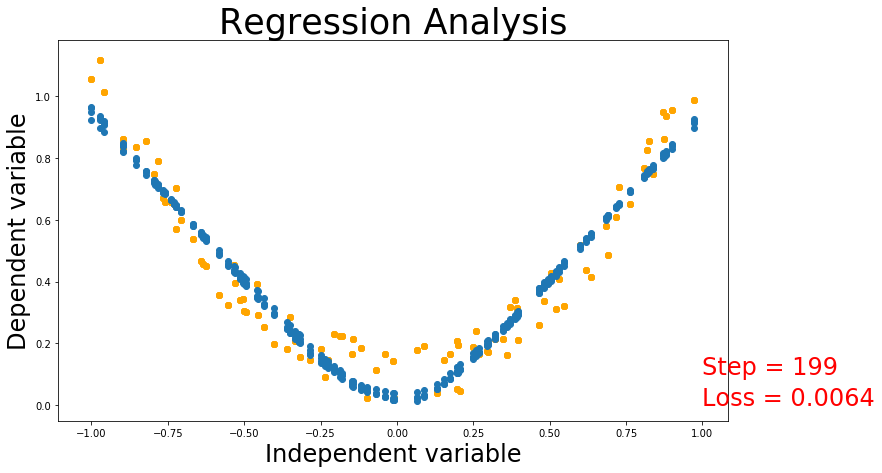

In [12]:
# Create model instance

if net_type == "real":
    net = RealNet(n_feature=input_feature, n_hidden=hidden_size, n_output=output_feature)
elif net_type == "quat":
    net = QuatNet(n_feature=input_feature, n_hidden=hidden_size, n_output=output_feature)
elif net_type == "phm":
    net = PHMNet(n=n, n_feature=input_feature, n_hidden=hidden_size, n_output=output_feature)

# Set the loader

if example_type == "linear":
    trainloader = trainloader_linear
    print("Linear regression task")
elif example_type == "nonlinear":
    trainloader = trainloader_nonlinear
    print("Nonlinear regression task")
    
# Take a look at the network
print(net)

# Setup optimizer and loss functions
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()
my_images = []
losses = []
    
fig, ax = plt.subplots(figsize=(12,7))

# Train the model
for t in range(200):
    for data_iter in trainloader:
        x, y = data_iter
        
    optimizer.zero_grad()  
    prediction = net(x)
    loss = loss_func(prediction, y)
    losses.append(loss.item())
        
    loss.backward()
    optimizer.step()
    
    # Print losses
    if t%10 == 0:
        print("Loss", loss.item())

    # Plot and show learning process
    plt.cla()
    ax.set_title('Regression Analysis', fontsize=35)
    ax.set_xlabel('Independent variable', fontsize=24)
    ax.set_ylabel('Dependent variable', fontsize=24)
    ax.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
    ax.scatter(x.data.numpy(), prediction.data.numpy())
    ax.text(1.0, 0.1, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
    ax.text(1.0, 0, 'Loss = %.4f' % loss.data.numpy(),
            fontdict={'size': 24, 'color':  'red'})

    fig.canvas.draw()       # draw the canvas
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)
    

# save images as a gif    
# imageio.mimsave('./curve_1.gif', my_images, fps=10)


### Toy example 2: Advanced Nonlinear regression tasks

#### Setup hyperparameters

`net_type` can be either: 

* `real` for real-valued network

* `quat` for quaternion-valued network

* `phm` for phm network

In [13]:
n_hidden1 = 200
n_hidden2 = 100
n = 4
BATCH_SIZE = 64
EPOCH = 200
net_type= "phm"
cuda = False

In [14]:
class RealNet(torch.nn.Module):
    '''
    Real-valued model
    '''
    
    def __init__(self, n_hidden1, n_hidden2):
        super(RealNet, self).__init__()
        self.net = torch.nn.Sequential(
        torch.nn.Linear(4, n_hidden1),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(n_hidden1, n_hidden2),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(n_hidden2, 4)
        )

    def forward(self, x):
        x = self.net(x)
        return x
    
class QuatNet(torch.nn.Module):
    '''
    Quaternion-valued model
    '''
    
    def __init__(self, n_hidden1, n_hidden2):
        super(QuatNet, self).__init__()
        self.net = torch.nn.Sequential(
        QuaternionLinear(4, n_hidden1),
        torch.nn.LeakyReLU(),
        QuaternionLinear(n_hidden1, n_hidden2),
        torch.nn.LeakyReLU(),
        QuaternionLinear(n_hidden2, 4)
        )

    def forward(self, x):
        x = self.net(x)
        return x
    
class PHMNet(torch.nn.Module):
    '''
    PHM model
    '''
    
    def __init__(self, n, n_hidden1, n_hidden2):
        super(PHMNet, self).__init__()
        self.net = torch.nn.Sequential(
        PHMLinear(n, 4, n_hidden1),
        torch.nn.LeakyReLU(),
        PHMLinear(n, n_hidden1, n_hidden2),
        torch.nn.LeakyReLU(),
        PHMLinear(n, n_hidden2, 4)
        )

    def forward(self, x):
        x = self.net(x)
        return x

#### Define training set

In [16]:
torch.manual_seed(1)

x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)  
y = torch.sin(x) + 0.2*torch.rand(x.size())                
x = torch.cat([x, x, x, x], dim=1)
y = torch.cat([y, y, y, y], dim=1)
x, y = Variable(x), Variable(y)

torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=1)

PHMNet(
  (net): Sequential(
    (0): PHMLinear(in_features=4, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): PHMLinear(in_features=200, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): PHMLinear(in_features=100, out_features=4, bias=True)
  )
)
Epoch 0
Loss 0.6266770958900452
Epoch 10
Loss 0.08025635778903961
Epoch 20
Loss 0.015544879250228405
Epoch 30
Loss 0.010057841427624226
Epoch 40
Loss 0.016352657228708267
Epoch 50
Loss 0.00959715060889721
Epoch 60
Loss 0.005304459482431412
Epoch 70
Loss 0.011443366296589375
Epoch 80
Loss 0.019731950014829636
Epoch 90
Loss 0.01145152933895588
Epoch 100
Loss 0.005232334136962891
Epoch 110
Loss 0.0066675059497356415
Epoch 120
Loss 0.01257566548883915
Epoch 130
Loss 0.00719949696213007
Epoch 140
Loss 0.004496352281421423
Epoch 150
Loss 0.004862362053245306
Epoch 160
Loss 0.014153741300106049
Epoch 170
Loss 0.008364247158169746
Epoch 180
Loss 0.006763459648936987
Epoch 190
Loss 0.0120810884

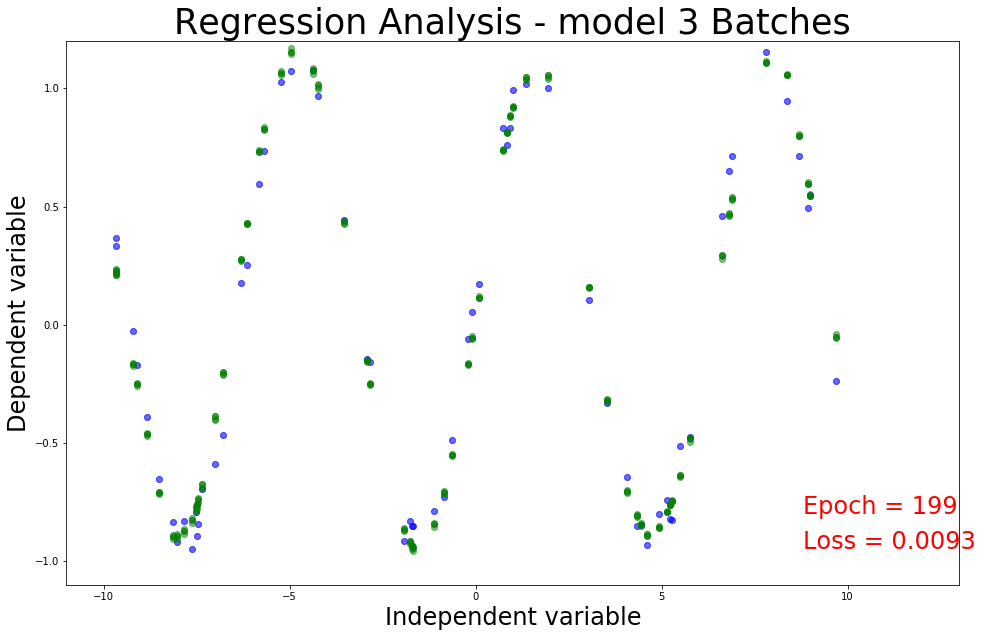

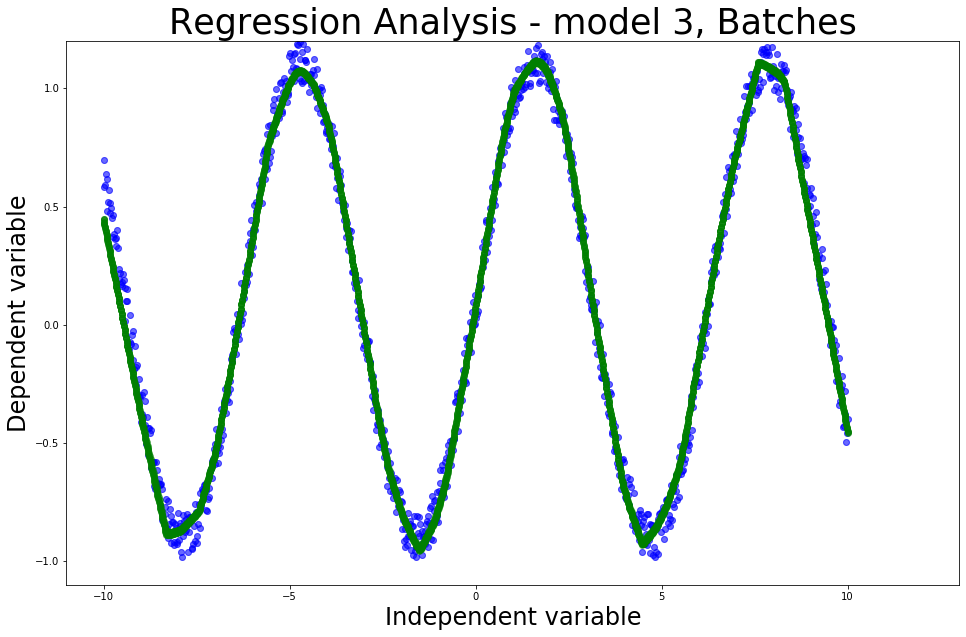

In [17]:
# Create model instance
if net_type == "real":
    net = RealNet(n_hidden1=n_hidden1, n_hidden2=n_hidden2)
elif net_type == "quat":
    net = QuatNet(n_hidden1=n_hidden1, n_hidden2=n_hidden2)
elif net_type == "phm":
    net = PHMNet(n=n, n_hidden1=n_hidden1, n_hidden2=n_hidden2)
    
# Take a look a the model and mode it to cuda
print(net)
if cuda:
    net = net.cuda()

# Setup optimizer and loss function
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

my_images = []
fig, ax = plt.subplots(figsize=(16,10))

# Run training
for epoch in range(EPOCH):
    batch_loss = []
    for step, (b_x, b_y) in enumerate(loader):
        
#         b_x = Variable(batch_x)
#         b_y = Variable(batch_y)        
        if cuda:
            b_x = b_x.cuda()
            b_y = b_y.cuda()

        prediction = net(b_x)

        loss = loss_func(prediction, b_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if step == 1:
            # Plot and show learning process
            plt.cla()
            ax.set_title('Regression Analysis - model 3 Batches', fontsize=35)
            ax.set_xlabel('Independent variable', fontsize=24)
            ax.set_ylabel('Dependent variable', fontsize=24)
            ax.set_xlim(-11.0, 13.0)
            ax.set_ylim(-1.1, 1.2)
            if not cuda:
                ax.scatter(b_x.data.numpy(), b_y.data.numpy(), color = "blue", alpha=0.2)
                ax.scatter(b_x.data.numpy(), prediction.data.numpy(), color='green', alpha=0.5)
            elif cuda:
                ax.scatter(b_x.data.cpu().numpy(), b_y.data.cpu().numpy(), color = "blue", alpha=0.2)
                ax.scatter(b_x.data.cpu().numpy(), prediction.data.cpu().numpy(), color='green', alpha=0.5)

            ax.text(8.8, -0.8, 'Epoch = %d' % epoch,
                    fontdict={'size': 24, 'color':  'red'})
            ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.cpu().numpy(),
                    fontdict={'size': 24, 'color':  'red'})

            fig.canvas.draw()       # draw the canvas
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            my_images.append(image)

    if epoch%10==0:
        print("Epoch", epoch)
        print("Loss", loss.item())


# save images as a gif    
# imageio.mimsave('./curve_2_model_3_batch.gif', my_images, fps=12)


fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title('Regression Analysis - model 3, Batches', fontsize=35)
ax.set_xlabel('Independent variable', fontsize=24)
ax.set_ylabel('Dependent variable', fontsize=24)
ax.set_xlim(-11.0, 13.0)
ax.set_ylim(-1.1, 1.2)
ax.scatter(x.data.cpu().numpy(), y.data.cpu().numpy(), color = "blue", alpha=0.2)
prediction = net(x.cuda())     # input x and predict based on x
ax.scatter(x.data.cpu().numpy(), prediction.data.cpu().numpy(), color='green', alpha=0.5)
plt.savefig('curve_2_model_3_batches.png')
plt.show()

In [18]:
# Count number of model parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
count_parameters(net)

5796